# Edafa on ImageNet dataset

This notebook shows an example on how to use Edafa to obtain better results on **classification task**. We use [ImageNet](http://www.image-net.org/) dataset which has **1000 classes**. We use *pytorch* and pretrained weights of VGG16. At the end we compare results of the same model with and without augmentations.

#### Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
# add our package directory to the path
import sys
sys.path.append('../../')

In [18]:
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Constants

In [4]:
# Filename to use for comparison (3 sample files are given in 'data' folder)
FILE = '000042'

# Input size of the deeplab model
IN_SIZE = 224

#### get labels

In [5]:
# Let's get our class labels.
labels = []
with open('labels.txt') as f:
    for line in f:
        labels.append(line.split(': ')[-1][1:-3])

#### Now we build our model (using pretrained weights)

In [6]:
model = models.vgg16(pretrained=True)

#### Read and preprocess image

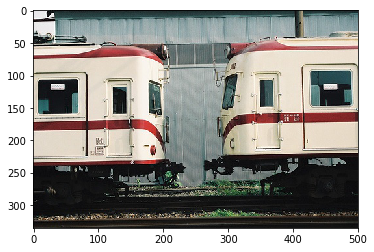

In [7]:
img_path = '../data/images/%s.jpg'%FILE
img = plt.imread(img_path)
plt.imshow(img)

In [8]:
transform_pipeline = transforms.Compose([ transforms.ToPILImage(),
                                        transforms.Resize((IN_SIZE,IN_SIZE)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

In [9]:
x = transform_pipeline(img)
x = x.unsqueeze(0)
x = Variable(x)

### Exp1: Predict image without augmentation

In [10]:
pred = model(x)
pred_without = pred.data.numpy()

### Exp2: Using same model with Edafa

#### step 1: import base class `ClassPredictor`

In [11]:
from edafa import ClassPredictor

#### step 2: inherit `ClassPredictor` and implement the main virtual functions: predict_patches()

In [12]:
class myPredictor(ClassPredictor):
    def __init__(self,vgg16,pipeline,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.model = vgg16
        self.pipe = pipeline
        
    def predict_patches(self,patches):
        preds = []
        for i in range(patches.shape[0]):
            processed = self.pipe(patches[i])
            processed = processed.unsqueeze(0)
            processed = Variable(processed)
            pred = self.model(processed)
            preds.append(pred.data.numpy())
        return np.array(preds)

#### step 3: make an instance of your class with the correct parameters

In [13]:
p = myPredictor(model,transform_pipeline,"../../conf/imagenet.json")

#### step 4: call predict_images()

In [14]:
preds_with = p.predict_images([img])

In [15]:
## Compare results of Exp1 and Exp2

In [16]:
print('Predicted without augmentation: ', labels[pred_without.argmax()])
print('Predicted with augmentation:', labels[preds_with.argmax()])

Predicted without augmentation:  electric locomotive
Predicted with augmentation: passenger car, coach, carriage


We can clearly see from the object image that it's a **desktop computer**.
With *no augmentation* the top prediction is **television**.
With *augmentation* the top prediction is **desktop computer**

### Conclusion
Results showed that with the exact same model and by applying Edafa we can obtain better results!